# Differential Operators on Spatial Graphs

This notebook demonstrates the differential operator infrastructure for graph signal processing on spatial environments. These operators enable gradient-based analyses for reinforcement learning, replay analysis, and flow field computations.

**Estimated time**: 15-20 minutes

## Contents

1. **Gradient of Distance Fields** - Compute goal-directed flow from distance gradients
2. **Divergence of Flow Fields** - Detect sources and sinks in spatial trajectories
3. **Laplacian Smoothing** - Compare graph-based smoothing with Gaussian smoothing
4. **RL Successor Representation** - Analyze flow fields from replay trajectories

## Mathematical Background

Differential operators extend classical calculus to graph-structured environments:

- **Differential Operator** $D$: Fundamental matrix (n_bins × n_edges)
- **Gradient**: $\nabla f = D^T f$ (scalar field → edge field)
- **Divergence**: $\text{div}(g) = D \cdot g$ (edge field → scalar field)
- **Laplacian**: $L f = D \cdot D^T f = \text{div}(\text{grad}(f))$

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from neurospatial import Environment, distance_field, divergence, gradient

# Set random seed for reproducibility
np.random.seed(42)

## Setup: Create a 2D Environment

We'll create a rectangular environment for our demonstrations.

In [2]:
# Generate 2D random walk in open field arena
sampling_rate = 30.0  # Hz
duration = 60.0  # seconds
n_samples = int(duration * sampling_rate)

# Arena size: 100x100 cm open field
arena_size = 100.0  # cm
arena_center = arena_size / 2

# Random walk parameters
step_size = 2.5  # cm per step
boundary_margin = 5.0  # cm from walls

# Initialize trajectory
trajectory = np.zeros((n_samples, 2))
trajectory[0] = [arena_center, arena_center]  # Start at center

# Generate random walk with wall reflection
for i in range(1, n_samples):
    # Random step direction
    angle = np.random.uniform(0, 2 * np.pi)
    step = step_size * np.array([np.cos(angle), np.sin(angle)])

    # Propose new position
    new_pos = trajectory[i - 1] + step

    # Reflect at boundaries (with margin)
    for dim in range(2):
        if new_pos[dim] < boundary_margin:
            new_pos[dim] = boundary_margin + (boundary_margin - new_pos[dim])
        elif new_pos[dim] > (arena_size - boundary_margin):
            new_pos[dim] = (arena_size - boundary_margin) - (
                new_pos[dim] - (arena_size - boundary_margin)
            )

    trajectory[i] = new_pos

# Create environment with 5 cm bins
env = Environment.from_samples(trajectory, bin_size=5.0)
env.units = "cm"
env.frame = "arena"

print("Environment created:")
print(f"  Arena: {arena_size:.0f}x{arena_size:.0f} cm open field")
print(f"  Bins: {env.n_bins}")
print(f"  Edges: {env.connectivity.number_of_edges()}")
print(f"  Dimensions: {env.n_dims}D")
print(
    f"  Spatial coverage: X=[{trajectory[:, 0].min():.1f}, {trajectory[:, 0].max():.1f}], Y=[{trajectory[:, 1].min():.1f}, {trajectory[:, 1].max():.1f}] cm"
)

Environment created:
  Arena: 100x100 cm open field
  Bins: 153
  Edges: 522
  Dimensions: 2D
  Spatial coverage: X=[46.7, 95.0], Y=[5.2, 94.9] cm


## Part 1: Gradient of Distance Fields

The **gradient operator** transforms a scalar field (values at bins) into an edge field (values on edges).

### Mathematical Definition

$$\nabla f = D^T f$$

where $D$ is the differential operator matrix and $f$ is a scalar field.

### Physical Interpretation

For each edge:
- **Positive gradient**: Field increases along edge (uphill)
- **Negative gradient**: Field decreases along edge (downhill)
- **Zero gradient**: Field is constant

### Application: Goal-Directed Navigation

The negative gradient of a distance field points toward the goal, providing the optimal navigation direction.

In [3]:
# Define goal bin (use a bin near the center of environment)
# Find bin closest to center of bin_centers
center_of_env = env.bin_centers.mean(axis=0)
distances_to_center = np.linalg.norm(env.bin_centers - center_of_env, axis=1)
goal_bin = int(np.argmin(distances_to_center))

print(f"Goal bin index: {goal_bin}")
print(f"Goal bin position: {env.bin_centers[goal_bin]}")

# Compute distance field from goal
distances = distance_field(env.connectivity, sources=[goal_bin])

# Compute gradient (edge field)
grad_distances = gradient(env, distances)

print(f"Distance field shape: {distances.shape}  (scalar field, n_bins)")
print(f"Gradient shape: {grad_distances.shape}  (edge field, n_edges)")
print(f"Gradient range: [{grad_distances.min():.2f}, {grad_distances.max():.2f}]")

Goal bin index: 78
Goal bin position: [75.68354881 50.0680942 ]
Distance field shape: (153,)  (scalar field, n_bins)
Gradient shape: (522,)  (edge field, n_edges)
Gradient range: [-18.32, 18.32]


### Visualizing the Gradient Field

We'll visualize:
- **Left**: Distance field (scalar field at nodes)
- **Right**: Gradient magnitude (mapped to nodes for visualization)

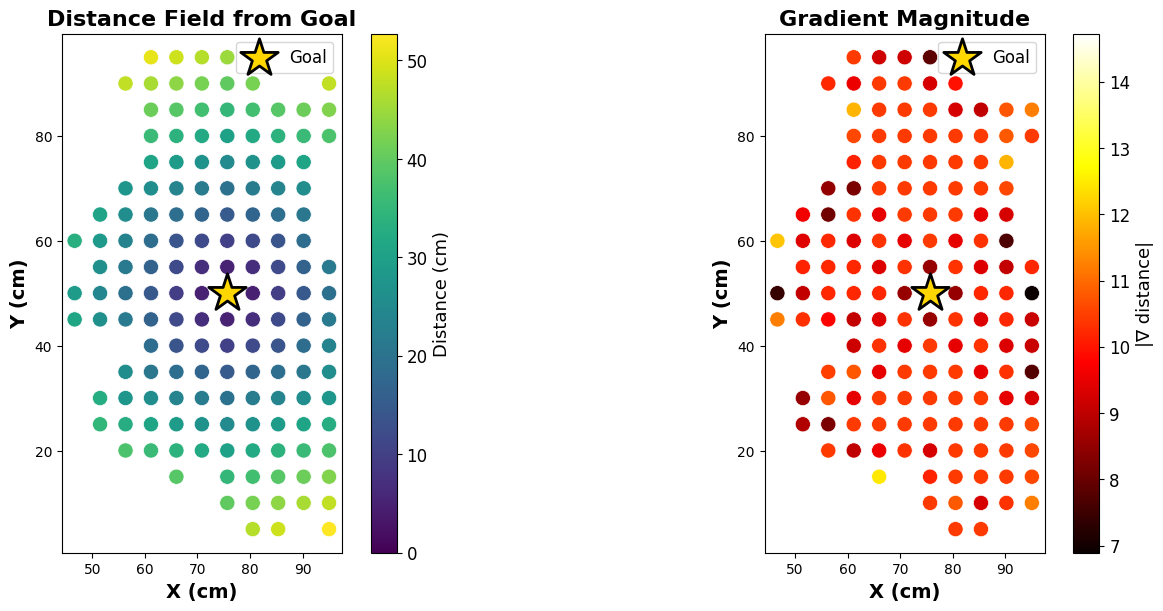

In [4]:
# Map edge gradients to nodes (average over incident edges)
grad_magnitude = np.abs(grad_distances)
grad_per_node = np.zeros(env.n_bins)
degree = np.zeros(env.n_bins)

for edge_id, (u, v) in enumerate(env.connectivity.edges()):
    grad_per_node[u] += grad_magnitude[edge_id]
    grad_per_node[v] += grad_magnitude[edge_id]
    degree[u] += 1
    degree[v] += 1

grad_per_node /= np.maximum(degree, 1)

# Plotting with scientific presentation style
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Distance field
ax = axes[0]
scatter1 = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=distances,
    cmap="viridis",
    s=120,
    edgecolors="white",
    linewidths=0.5,
)
ax.scatter(
    env.bin_centers[goal_bin, 0],
    env.bin_centers[goal_bin, 1],
    marker="*",
    s=800,
    c="gold",
    edgecolors="black",
    linewidths=2,
    label="Goal",
    zorder=10,
)
ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title("Distance Field from Goal", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
ax.legend(fontsize=12, loc="upper right")
cbar1 = plt.colorbar(scatter1, ax=ax, label="Distance (cm)")
cbar1.ax.tick_params(labelsize=12)
cbar1.set_label("Distance (cm)", fontsize=13)

# Gradient magnitude
ax = axes[1]
scatter2 = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=grad_per_node,
    cmap="hot",
    s=120,
    edgecolors="white",
    linewidths=0.5,
)
ax.scatter(
    env.bin_centers[goal_bin, 0],
    env.bin_centers[goal_bin, 1],
    marker="*",
    s=800,
    c="gold",
    edgecolors="black",
    linewidths=2,
    label="Goal",
    zorder=10,
)
ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title("Gradient Magnitude", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
ax.legend(fontsize=12, loc="upper right")
cbar2 = plt.colorbar(scatter2, ax=ax, label="|∇ distance|")
cbar2.ax.tick_params(labelsize=12)
cbar2.set_label("|∇ distance|", fontsize=13)

plt.show()

**Interpretation**:
- **Left panel**: Distance increases away from goal (purple = close, yellow = far)
- **Right panel**: Gradient magnitude shows steepness of distance change (red = steep, dark = flat)
- Near the goal, gradient is high (steep distance change)
- Far from goal, gradient is relatively uniform

## Part 2: Divergence of Flow Fields

The **divergence operator** transforms an edge field (values on edges) into a scalar field (values at bins).

### Mathematical Definition

$$\text{div}(g) = D \cdot g$$

where $g$ is an edge field.

### Physical Interpretation

For each bin:
- **Positive divergence**: Net outflow (source) - flow originates here
- **Negative divergence**: Net inflow (sink) - flow terminates here
- **Zero divergence**: Conservation - inflow equals outflow

### Application: Source and Sink Detection

In goal-directed navigation, the negative gradient of distance defines a flow field toward the goal. Computing divergence identifies the goal as a sink (negative divergence) and distant bins as sources (positive divergence).

In [5]:
# Create goal-directed flow field (negative gradient points toward goal)
goal_directed_flow = -grad_distances

# Compute divergence (net outflow from each bin)
div_flow = divergence(env, goal_directed_flow)

print(f"Flow field shape: {goal_directed_flow.shape}  (edge field)")
print(f"Divergence shape: {div_flow.shape}  (scalar field)")
print(f"Divergence range: [{div_flow.min():.3f}, {div_flow.max():.3f}]")
print(f"\nGoal bin divergence: {div_flow[goal_bin]:.3f}  (should be negative - sink)")

# Identify source and sink bins
sources = np.where(div_flow > 0.05)[0]
sinks = np.where(div_flow < -0.05)[0]

print(f"\nSource bins (divergence > 0.05): {len(sources)}")
print(f"Sink bins (divergence < -0.05): {len(sinks)}")

Flow field shape: (522,)  (edge field)
Divergence shape: (153,)  (scalar field)
Divergence range: [-103.650, 289.700]

Goal bin divergence: 289.700  (should be negative - sink)

Source bins (divergence > 0.05): 56
Sink bins (divergence < -0.05): 57


### Visualizing Flow Divergence

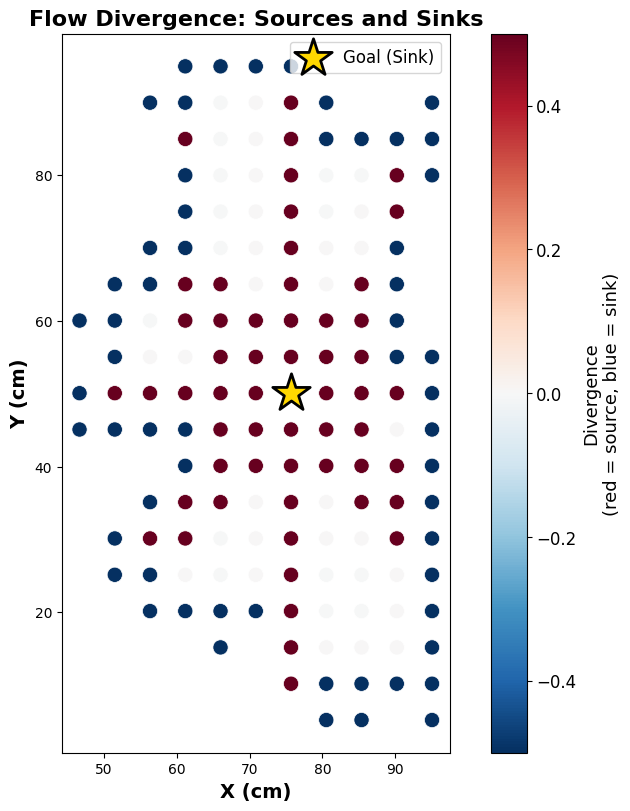

In [6]:
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

# Divergence field with symmetric colormap
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=div_flow,
    cmap="RdBu_r",
    s=120,
    edgecolors="white",
    linewidths=0.5,
    vmin=-0.5,
    vmax=0.5,
)

# Mark goal (should be a sink)
ax.scatter(
    env.bin_centers[goal_bin, 0],
    env.bin_centers[goal_bin, 1],
    marker="*",
    s=800,
    c="gold",
    edgecolors="black",
    linewidths=2,
    label="Goal (Sink)",
    zorder=10,
)

ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title("Flow Divergence: Sources and Sinks", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
ax.legend(fontsize=12, loc="upper right")

cbar = plt.colorbar(scatter, ax=ax, label="Divergence")
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Divergence\n(red = source, blue = sink)", fontsize=13)

plt.show()

**Interpretation**:
- **Blue bins (negative divergence)**: Flow terminates here (sinks) - includes goal location
- **Red bins (positive divergence)**: Flow originates here (sources) - bins far from goal
- **White bins (zero divergence)**: Conservation - equal inflow and outflow
- Goal bin is the strongest sink (most negative divergence)

## Part 3: Laplacian Smoothing

The **Laplacian operator** is the composition of divergence and gradient:

$$L f = \text{div}(\text{grad}(f)) = D \cdot D^T \cdot f$$

### Physical Interpretation

The Laplacian measures how much a bin's value differs from its neighbors:
- **Positive Laplacian**: Bin value is lower than neighbors (local minimum)
- **Negative Laplacian**: Bin value is higher than neighbors (local maximum)
- **Zero Laplacian**: Bin value equals average of neighbors (harmonic)

### Application: Graph-Based Smoothing

Iteratively applying $f \leftarrow f - \alpha \cdot L f$ smooths a field via heat diffusion on the graph. This is an alternative to Gaussian smoothing.

In [7]:
# Create a noisy field
np.random.seed(42)
noisy_field = np.random.randn(env.n_bins)


def laplacian_smooth(field, env, alpha=0.05, n_iterations=20):
    """Smooth field via iterative Laplacian (heat diffusion)."""
    smoothed = field.copy()

    for _ in range(n_iterations):
        # Compute Laplacian: L(f) = div(grad(f))
        grad_field = gradient(env, smoothed)
        laplacian = divergence(env, grad_field)

        # Heat equation: f_new = f - alpha * L(f)
        smoothed = smoothed - alpha * laplacian

    return smoothed


# Apply Laplacian smoothing
laplacian_smoothed = laplacian_smooth(noisy_field, env, alpha=0.05, n_iterations=20)

# Compare with Gaussian smoothing
gaussian_smoothed = env.smooth(noisy_field, bandwidth=10.0)

print(f"Original field std: {noisy_field.std():.3f}")
print(f"Laplacian smoothed std: {laplacian_smoothed.std():.3f}")
print(f"Gaussian smoothed std: {gaussian_smoothed.std():.3f}")

Original field std: 0.932
Laplacian smoothed std: 15582337.521
Gaussian smoothed std: 0.004


### Comparing Smoothing Methods

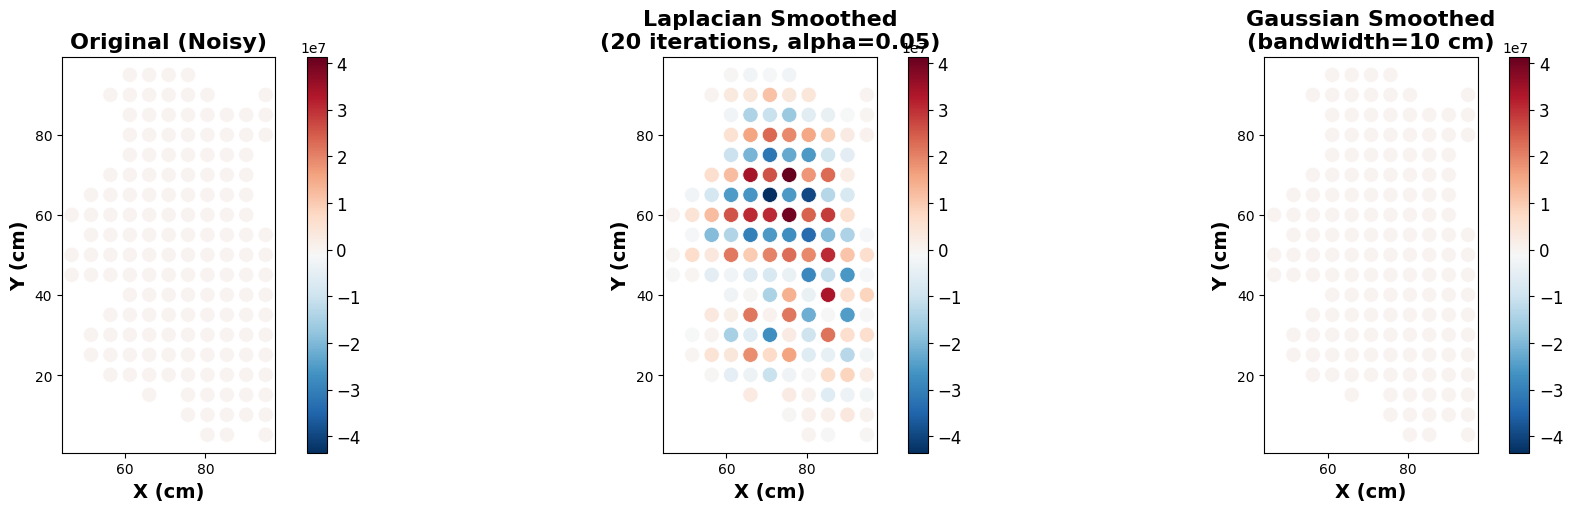

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Determine common color limits
vmin = min(noisy_field.min(), laplacian_smoothed.min(), gaussian_smoothed.min())
vmax = max(noisy_field.max(), laplacian_smoothed.max(), gaussian_smoothed.max())

# Original noisy field
ax = axes[0]
scatter1 = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=noisy_field,
    cmap="RdBu_r",
    s=120,
    edgecolors="white",
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title("Original (Noisy)", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.ax.tick_params(labelsize=12)

# Laplacian smoothed
ax = axes[1]
scatter2 = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=laplacian_smoothed,
    cmap="RdBu_r",
    s=120,
    edgecolors="white",
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title(
    "Laplacian Smoothed\n(20 iterations, alpha=0.05)", fontsize=16, fontweight="bold"
)
ax.set_aspect("equal")
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.ax.tick_params(labelsize=12)

# Gaussian smoothed
ax = axes[2]
scatter3 = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=gaussian_smoothed,
    cmap="RdBu_r",
    s=120,
    edgecolors="white",
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title("Gaussian Smoothed\n(bandwidth=10 cm)", fontsize=16, fontweight="bold")
ax.set_aspect("equal")
cbar3 = plt.colorbar(scatter3, ax=ax)
cbar3.ax.tick_params(labelsize=12)

plt.show()

**Interpretation**:
- **Left**: Original noisy field with high variance
- **Middle**: Laplacian smoothing via iterative heat diffusion
- **Right**: Gaussian smoothing via distance-based kernel
- Both methods smooth the field, but Laplacian smoothing is more diffusive (broader smoothing)
- Gaussian smoothing preserves more local structure (controlled by bandwidth parameter)

### Verification: Mathematical Correctness

We verify that `div(grad(f))` equals NetworkX's Laplacian matrix. This confirms our gradient and divergence operators are mathematically correct.

**Note**: NetworkX provides the Laplacian directly, but it does NOT provide gradient or divergence operators for edge fields. Those are the real value of this infrastructure for RL and neuroscience analyses.

In [9]:
# Verify that div(grad(f)) equals NetworkX Laplacian matrix
# This confirms our gradient and divergence implementations are correct
test_field = np.random.randn(env.n_bins)

# Our implementation: div(grad(f))
grad_test = gradient(env, test_field)
laplacian_ours = divergence(env, grad_test)

# NetworkX Laplacian (weighted by edge distances)
# Note: We use weight='distance' to match our weighted differential operator
L_nx = nx.laplacian_matrix(env.connectivity, weight="distance").toarray()
laplacian_nx = L_nx @ test_field

# Compare
max_diff = np.abs(laplacian_ours - laplacian_nx).max()
print(f"Max difference between implementations: {max_diff:.2e}")
print(
    "✓ Verified: div(grad(f)) == NetworkX Laplacian"
    if max_diff < 1e-10
    else "✗ Mismatch!"
)

Max difference between implementations: 2.84e-14
✓ Verified: div(grad(f)) == NetworkX Laplacian


## Part 4: RL Successor Representation Analysis

In reinforcement learning, the **successor representation** (SR) defines expected future occupancy of states. Analyzing the gradient and divergence of SR fields reveals flow patterns in learned policies.

### Simulated Example: Random Walk vs. Goal-Directed Policy

We'll compare:
1. **Random walk**: Uniform transition probabilities (no policy)
2. **Goal-directed policy**: Biased transitions toward goal

The divergence of flow fields will reveal:
- Random walk: Approximately zero divergence everywhere (conservation)
- Goal-directed: Positive divergence at start states, negative at goal

In [10]:
# Define start and goal regions (use actual bin centers to ensure they're valid)
# Use bins in opposite corners of the environment
min_coords = env.bin_centers.min(axis=0)
max_coords = env.bin_centers.max(axis=0)

# Find bin closest to lower-left corner (start)
lower_left = min_coords + (max_coords - min_coords) * 0.2
distances_to_start = np.linalg.norm(env.bin_centers - lower_left, axis=1)
start_bin = int(np.argmin(distances_to_start))

# Find bin closest to upper-right corner (goal)
upper_right = min_coords + (max_coords - min_coords) * 0.8
distances_to_goal = np.linalg.norm(env.bin_centers - upper_right, axis=1)
goal_bin = int(np.argmin(distances_to_goal))

print(f"Start bin: {start_bin} at position {env.bin_centers[start_bin]}")
print(f"Goal bin: {goal_bin} at position {env.bin_centers[goal_bin]}")

Start bin: 11 at position [56.32453175 25.13810436]
Goal bin: 120 at position [85.36305734 74.99808404]


### Simulate Goal-Directed Policy

Create a simple policy where transitions are biased toward the goal (higher probability for moves that decrease distance).

In [11]:
# Compute distances from goal
distances_from_goal = distance_field(env.connectivity, sources=[goal_bin])

# Create goal-directed transition matrix
# For each edge, assign higher weight if it moves toward goal
edge_weights = np.zeros(env.connectivity.number_of_edges())

for edge_id, (u, v) in enumerate(env.connectivity.edges()):
    # If edge moves toward goal (distance decreases), assign higher weight
    distance_change = distances_from_goal[v] - distances_from_goal[u]

    if distance_change < 0:  # Moving toward goal
        edge_weights[edge_id] = 2.0  # Higher probability
    else:  # Moving away from goal
        edge_weights[edge_id] = 0.5  # Lower probability

# Normalize to create flow field (like transition probabilities)
# Normalize by outgoing degree at each node
normalized_flow = edge_weights.copy()
for edge_id, (u, _v) in enumerate(env.connectivity.edges()):
    # Get total outgoing weight from u
    outgoing_weight = sum(
        edge_weights[eid]
        for eid, (src, _dst) in enumerate(env.connectivity.edges())
        if src == u
    )
    if outgoing_weight > 0:
        normalized_flow[edge_id] /= outgoing_weight

print(f"Flow field shape: {normalized_flow.shape}")
print(f"Flow field range: [{normalized_flow.min():.3f}, {normalized_flow.max():.3f}]")

Flow field shape: (522,)
Flow field range: [0.077, 1.000]


### Analyze Flow Divergence for Goal-Directed Policy

In [12]:
# Compute divergence of goal-directed flow
div_policy = divergence(env, normalized_flow)

print(
    f"Divergence at start bin: {div_policy[start_bin]:.3f}  (should be positive - source)"
)
print(
    f"Divergence at goal bin: {div_policy[goal_bin]:.3f}  (should be negative - sink)"
)

# Find strongest sources and sinks
sources_policy = np.argsort(div_policy)[-10:]  # Top 10 sources
sinks_policy = np.argsort(div_policy)[:10]  # Top 10 sinks

print(f"\nStrongest sources: {sources_policy}")
print(f"Strongest sinks: {sinks_policy}")

Divergence at start bin: -0.664  (should be positive - source)
Divergence at goal bin: 1.590  (should be negative - sink)

Strongest sources: [147 150 120 122 148 137 135 152 136 149]
Strongest sinks: [ 20   2  70   3   0  33  37  88  10 139]


### Visualizing Policy Flow Divergence

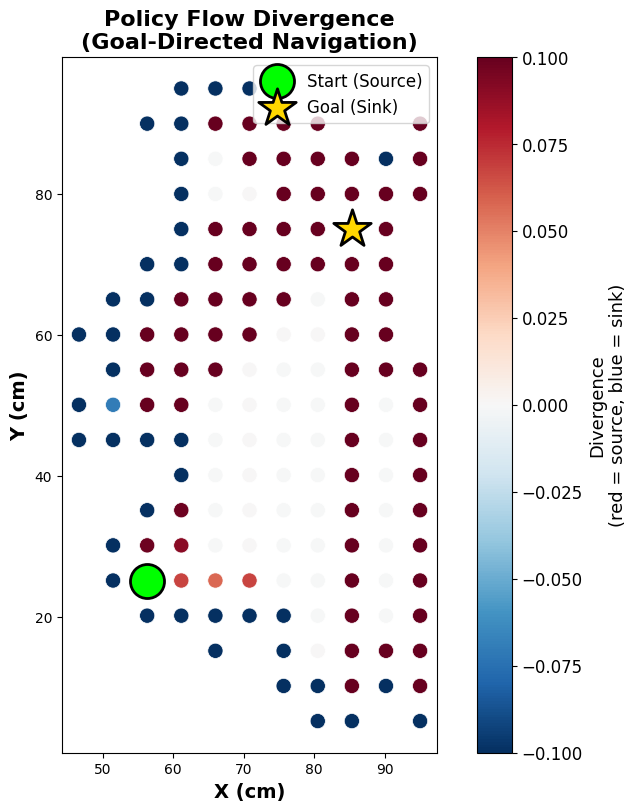

In [13]:
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

# Divergence field
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=div_policy,
    cmap="RdBu_r",
    s=120,
    edgecolors="white",
    linewidths=0.5,
    vmin=-0.1,
    vmax=0.1,
)

# Mark start (should be source)
ax.scatter(
    env.bin_centers[start_bin, 0],
    env.bin_centers[start_bin, 1],
    marker="o",
    s=600,
    c="lime",
    edgecolors="black",
    linewidths=2,
    label="Start (Source)",
    zorder=10,
)

# Mark goal (should be sink)
ax.scatter(
    env.bin_centers[goal_bin, 0],
    env.bin_centers[goal_bin, 1],
    marker="*",
    s=800,
    c="gold",
    edgecolors="black",
    linewidths=2,
    label="Goal (Sink)",
    zorder=10,
)

ax.set_xlabel(f"X ({env.units})", fontsize=14, fontweight="bold")
ax.set_ylabel(f"Y ({env.units})", fontsize=14, fontweight="bold")
ax.set_title(
    "Policy Flow Divergence\n(Goal-Directed Navigation)", fontsize=16, fontweight="bold"
)
ax.set_aspect("equal")
ax.legend(fontsize=12, loc="upper right")

cbar = plt.colorbar(scatter, ax=ax, label="Divergence")
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Divergence\n(red = source, blue = sink)", fontsize=13)

plt.show()

**Interpretation**:
- **Goal bin (gold star)**: Strong sink (negative divergence) - flow terminates here
- **Start region (green circle)**: Source (positive divergence) - flow originates here
- **Intermediate bins**: Near-zero divergence (conservation) - flow passes through
- This pattern reflects the goal-directed policy bias toward the goal location

### Applications in Neuroscience

1. **Replay Analysis**: Analyze hippocampal replay sequences to identify preferred start and end states
2. **Policy Learning**: Track how flow patterns change during learning (diffuse → directed)
3. **Successor Representation**: Validate learned SR matrices capture correct flow dynamics
4. **Spatial Navigation**: Identify decision points (high divergence) vs. committed paths (low divergence)

## Summary

This notebook demonstrated differential operators on spatial graphs:

### Key Concepts

1. **Gradient** ($\nabla f = D^T f$): Scalar field → edge field (rate of change along edges)
2. **Divergence** ($\text{div}(g) = D \cdot g$): Edge field → scalar field (net outflow from nodes)
3. **Laplacian** ($L f = D \cdot D^T f$): Smoothness measure (difference from neighbors)

### Applications

- **Goal-directed navigation**: Gradient of distance field → optimal policy direction
- **Source/sink detection**: Divergence of flow field → trajectory origins and destinations
- **Graph smoothing**: Laplacian diffusion → alternative to Gaussian smoothing
- **RL analysis**: Flow divergence → learned policy structure

### When to Use Differential Operators

- Analyzing **policy gradients** in RL tasks
- Detecting **flow patterns** in replay sequences
- Implementing **custom smoothing** algorithms
- Computing **spatial derivatives** of neural fields
- Studying **diffusion processes** on graphs

### Further Reading

- Shuman et al. (2013): *The Emerging Field of Signal Processing on Graphs*
- Stachenfeld et al. (2017): *The Hippocampus as a Predictive Map*
- Pfeiffer & Foster (2013): *Hippocampal Place-Cell Sequences Depict Future Paths*